<a href="https://colab.research.google.com/github/Aakash3101/Deep-Learning/blob/master/ML/Deep_learning/pytorch_tutorials/cifar10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Loading the Dataset 

In [2]:
# Training Data
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
# Testing Data
test = CIFAR10(root='data/', train=False, download=False, transform=ToTensor())

In [32]:
len(test)

10000

In [33]:
len(dataset)

50000

In [34]:
batch_size = 128

In [35]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [36]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


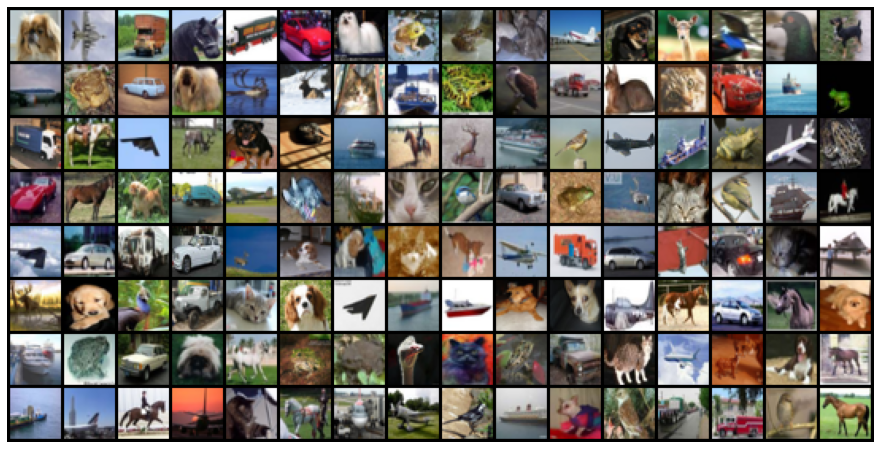

In [37]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## **Creating the model**

In [153]:
class CIFARModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 128, )
        self.drop1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(128, 32)
        self.linear3 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        out = F.relu(self.linear1(xb))
        out = F.relu(self.drop1(self.linear2(out)))
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate Predictions 
        loss = F.cross_entropy(out, labels)   # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate Predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc  = torch.stack(batch_accs).mean()        # combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [53]:
in_size = 3*32*32
out_size = 10

In [54]:
torch.cuda.is_available()

True

In [55]:
def get_default_device():
    """Pick GPU if available else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [56]:
device = get_default_device()
device

device(type='cuda')

In [57]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [58]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## **Training the model**

In [60]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [159]:
model = CIFARModel(in_size, out_size)
model

CIFARModel(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [160]:
to_device(model, device)

CIFARModel(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [161]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09775390475988388, 'val_loss': 2.3061883449554443}]

In [162]:
history += fit(20, 0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], val_loss: 1.9116, val_acc: 0.2984
Epoch [1], val_loss: 1.8080, val_acc: 0.3417
Epoch [2], val_loss: 1.7867, val_acc: 0.3545
Epoch [3], val_loss: 1.7282, val_acc: 0.3825
Epoch [4], val_loss: 1.7270, val_acc: 0.3850
Epoch [5], val_loss: 1.6776, val_acc: 0.4035
Epoch [6], val_loss: 1.6561, val_acc: 0.4094
Epoch [7], val_loss: 1.6502, val_acc: 0.4104
Epoch [8], val_loss: 1.6462, val_acc: 0.4096
Epoch [9], val_loss: 1.6101, val_acc: 0.4294
Epoch [10], val_loss: 1.5990, val_acc: 0.4285
Epoch [11], val_loss: 1.6007, val_acc: 0.4318
Epoch [12], val_loss: 1.6088, val_acc: 0.4288
Epoch [13], val_loss: 1.5872, val_acc: 0.4268
Epoch [14], val_loss: 1.6036, val_acc: 0.4297
Epoch [15], val_loss: 1.5975, val_acc: 0.4346
Epoch [16], val_loss: 1.6088, val_acc: 0.4347
Epoch [17], val_loss: 1.5816, val_acc: 0.4401
Epoch [18], val_loss: 1.5698, val_acc: 0.4400
Epoch [19], val_loss: 1.5930, val_acc: 0.4367


In [163]:
history += fit(10, 1e-4, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], val_loss: 1.5387, val_acc: 0.4521
Epoch [1], val_loss: 1.5338, val_acc: 0.4565
Epoch [2], val_loss: 1.5396, val_acc: 0.4528
Epoch [3], val_loss: 1.5454, val_acc: 0.4520
Epoch [4], val_loss: 1.5416, val_acc: 0.4537
Epoch [5], val_loss: 1.5379, val_acc: 0.4565
Epoch [6], val_loss: 1.5336, val_acc: 0.4579
Epoch [7], val_loss: 1.5331, val_acc: 0.4531
Epoch [8], val_loss: 1.5230, val_acc: 0.4578
Epoch [9], val_loss: 1.5306, val_acc: 0.4555


In [135]:
result = [evaluate(model, test_loader)]
result

[{'val_acc': 0.5248047113418579, 'val_loss': 1.3526562452316284}]

Text(0.5, 1.0, 'Loss & Accuracy vs No. of epochs')

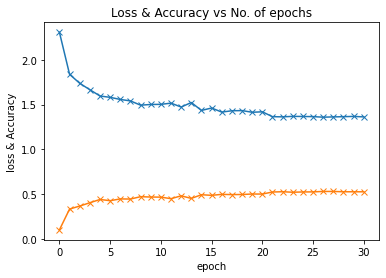

In [136]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]
plt.plot(losses, '-x', accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('loss & Accuracy')
plt.title('Loss & Accuracy vs No. of epochs')

### Observation Table
---
Model 1:

```
CIFARModel(
  (linear1): Linear(in_features=3072, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
)
```

---
| Model S.no | I (Lr, Epochs) | II (Lr, Epochs) | optimizer | val_acc | test_acc |
| --- | --- | --- | --- | --- | --- |
| 1 | (0.1, 20) | (0.01, 10) | SGD | 55.37 | 54.74 |
| 1 | (0.2, 20) | (0.1, 10) | SGD | 49.40 | 48.86 |
| 1 | (0.5, 20) | (0.1, 10) | SGD | 48.87 | 50.66 |
| 1 | (0.1, 30) | (0.01, 10) | SGD | 55.66 | 55.31 |
| 1 | (0.001, 20) | (0.0001, 10) | Adam | 53.04 | 53.34 |
| 1 | (0.0001, 20) | (1e-5, 10) | Adam | 51.62 | 52.17 |

---

In [15]:
torch.cuda.empty_cache()